In [18]:
import pandas as pd
import requests

# Fetch the data.
df = pd.read_csv("https://ourworldindata.org/grapher/monthly-co2-emissions-from-international-and-domestic-flights.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Fetch the metadata
metadata = requests.get("https://ourworldindata.org/grapher/monthly-co2-emissions-from-international-and-domestic-flights.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

In [19]:
df.head(1)

,Entity,Code,Day,ter_dom_m,ter_int_m
0,Afghanistan,AFG,2019-01-15,1576.6334,10899.172


In [20]:
pd.to_datetime(df['Day'])
df.head()

,Entity,Code,Day,ter_dom_m,ter_int_m
0,Afghanistan,AFG,2019-01-15,1576.6334,10899.172
1,Afghanistan,AFG,2019-02-15,1794.2830,10676.192
2,Afghanistan,AFG,2019-03-15,1409.3792,10475.162
3,Afghanistan,AFG,2019-04-15,2558.5806,12447.358
4,Afghanistan,AFG,2019-05-15,2011.3917,11834.152


In [21]:
co2 = df[(df['Entity'] == 'World') & (df['Day'] < '2024-01-15')]
co2.head()

,Entity,Code,Day,ter_dom_m,ter_int_m
13062,World,OWID_WRL,2019-01-15,25458934.0,44271290.0
13063,World,OWID_WRL,2019-02-15,23327330.0,39871720.0
13064,World,OWID_WRL,2019-03-15,23483454.0,40737690.0
13065,World,OWID_WRL,2019-04-15,25564624.0,44844636.0
13066,World,OWID_WRL,2019-05-15,26616754.0,46503204.0


In [22]:
co2 = co2.set_index('Day')
co2['total'] = co2['ter_dom_m'] + co2['ter_int_m']
co2.head()

,Entity,Code,ter_dom_m,ter_int_m,total
Day,,,,,
2019-01-15,World,OWID_WRL,25458934.0,44271290.0,69730224.0
2019-02-15,World,OWID_WRL,23327330.0,39871720.0,63199050.0
2019-03-15,World,OWID_WRL,23483454.0,40737690.0,64221144.0
2019-04-15,World,OWID_WRL,25564624.0,44844636.0,70409260.0
2019-05-15,World,OWID_WRL,26616754.0,46503204.0,73119958.0


In [26]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x = co2.index, y = co2['total'], mode = 'lines'))

fig.update_layout(title = 'Monthly CO2 Emissions from International and Domestic Flights',
                  xaxis_title = 'Date (Years)',
                  yaxis_title = 'CO2 Emissions (Million Tonnes)',
                  template = 'plotly_dark')

fig.show()

<Figure size 800x500 with 0 Axes>

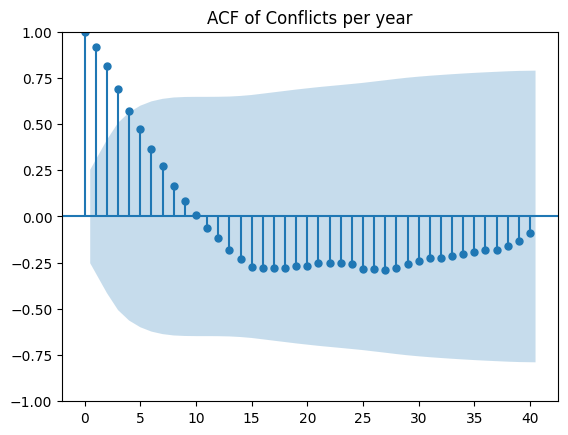

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot ACF of Apple closing prices
plt.figure(figsize=(8, 5))
plot_acf(co2['total'], lags=40)
plt.title("ACF of Conflicts per year")
plt.show()

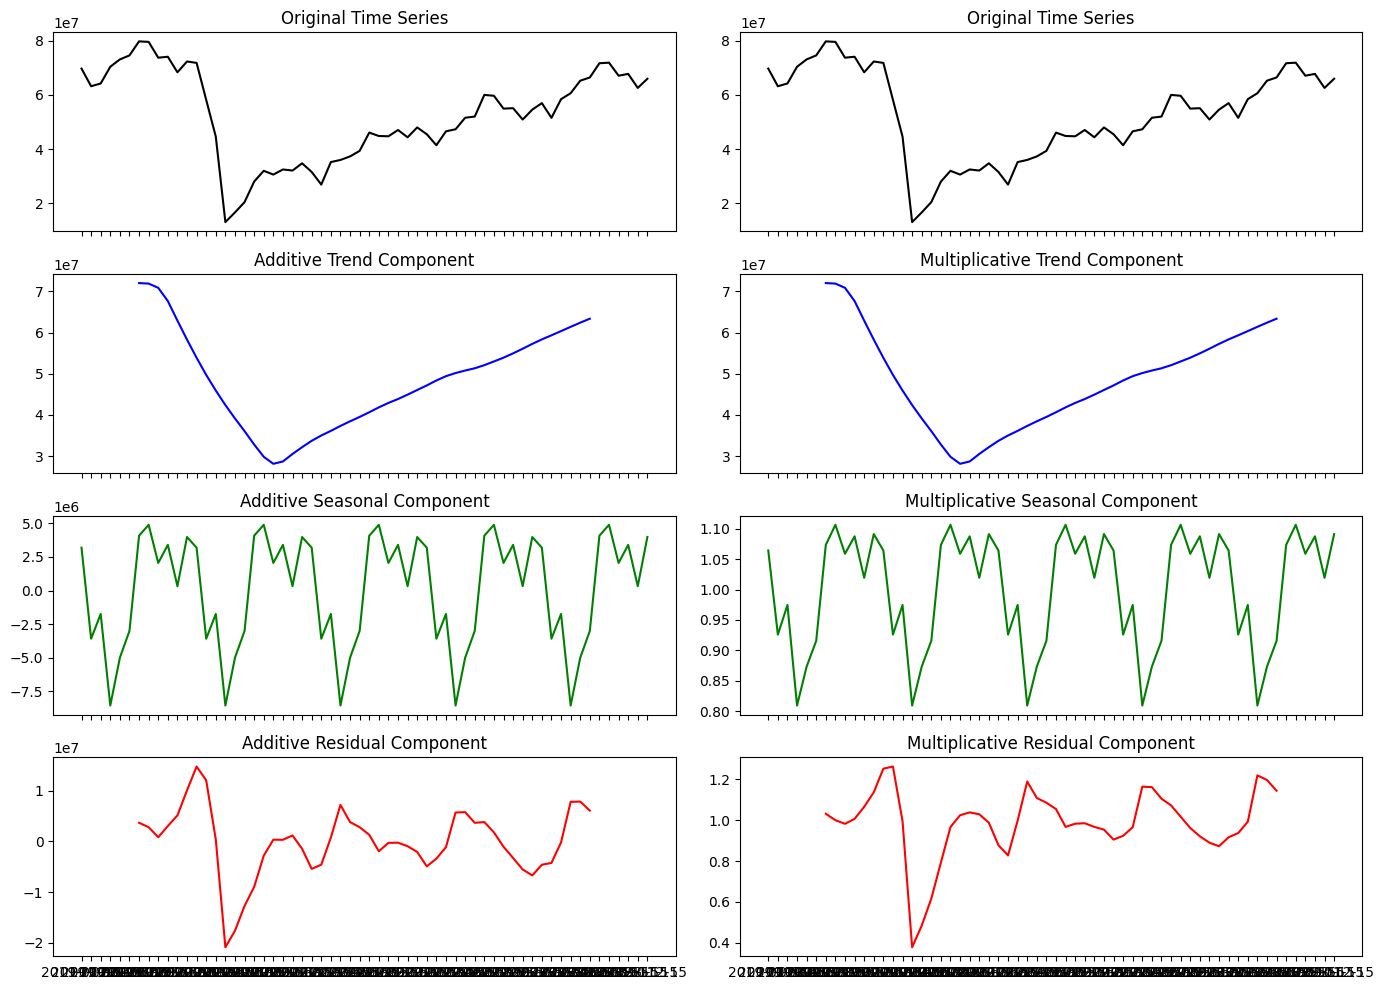

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(co2["total"], model="additive", period=12)
multiplicative_decomposition = seasonal_decompose(co2["total"], model="multiplicative", period=12)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Additive Decomposition Plots
axes[0, 0].plot(co2.index, co2["total"], color="black")
axes[0, 0].set_title("Original Time Series")

axes[1, 0].plot(co2.index, additive_decomposition.trend, color="blue")
axes[1, 0].set_title("Additive Trend Component")

axes[2, 0].plot(co2.index, additive_decomposition.seasonal, color="green")
axes[2, 0].set_title("Additive Seasonal Component")

axes[3, 0].plot(co2.index, additive_decomposition.resid, color="red")
axes[3, 0].set_title("Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(co2.index, co2["total"], color="black")
axes[0, 1].set_title("Original Time Series")

axes[1, 1].plot(co2.index, multiplicative_decomposition.trend, color="blue")
axes[1, 1].set_title("Multiplicative Trend Component")

axes[2, 1].plot(co2.index, multiplicative_decomposition.seasonal, color="green")
axes[2, 1].set_title("Multiplicative Seasonal Component")

axes[3, 1].plot(co2.index, multiplicative_decomposition.resid, color="red")
axes[3, 1].set_title("Multiplicative Residual Component")

plt.tight_layout()
plt.show()

In [29]:
# --- Perform ADF Test on Residuals (Assuming Additive is Best) ---
residuals = additive_decomposition.resid.dropna()
adf_result = adfuller(residuals)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

ADF Statistic: -4.6788
p-value: 0.0001


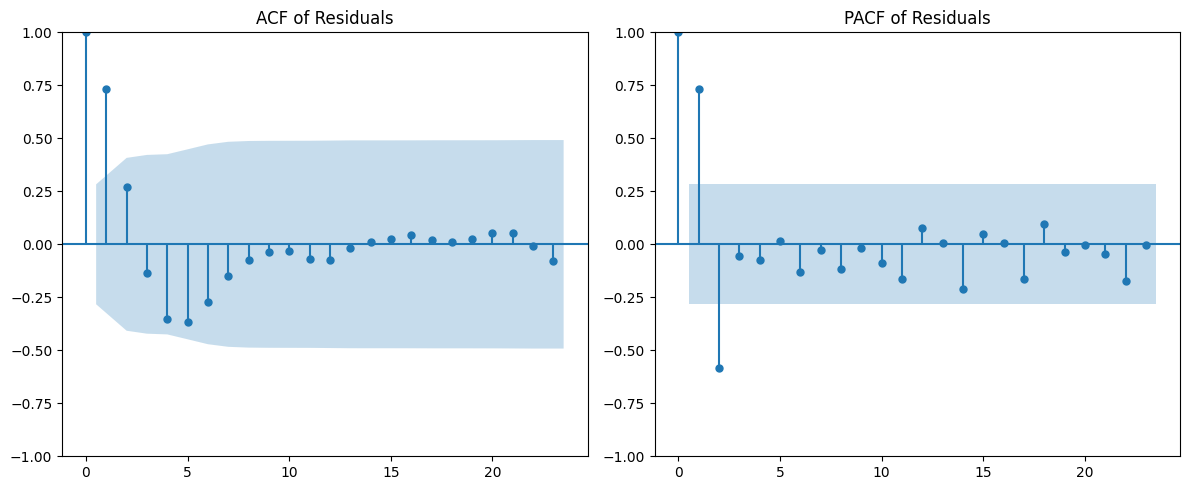

In [31]:
# ---  ACF and PACF Plots of Residuals ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(residuals, lags=23, ax=axes[0])
axes[0].set_title("ACF of Residuals")

# PACF plot
plot_pacf(residuals, lags=23, ax=axes[1])
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()

In [32]:
# --- Perform Ljung-Box Test ---
ljungbox_result = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_ljungbox = ljungbox_result["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")
print("Tests if data is whitenoise (if it is then no correllation) low p = not whitenoise")

Ljung-Box p-value: 0.0001
Tests if data is whitenoise (if it is then no correllation) low p = not whitenoise


In [34]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ensure the index is datetime
co2.index = pd.to_datetime(co2.index)

# Train-test split: Exclude the last 12 weeks for training
train_data = co2.iloc[:-12] # all data except last 12 weeks
test_data = co2.iloc[-12:]   # only last 12 weeks

# Fit Holt-Winters Exponential Smoothing model
hw_model = ExponentialSmoothing(
    train_data["total"],  # Use the "count" column
    trend="add",          # Additive trend
    seasonal="add",       # Additive seasonality
    seasonal_periods=12   # 52 weeks in a year (for weekly data)
).fit()

# Forecast the next 12 weeks
forecast_values = hw_model.forecast(steps=12)

# Estimate confidence intervals using residual standard deviation
residuals = train_data["total"] - hw_model.fittedvalues
std_dev = np.std(residuals)
confidence_interval = 1.96 * std_dev  # 95% Confidence Interval

# Convert forecasted values to a Pandas Series with correct weekly index
forecast_series = pd.Series(forecast_values.values, index=test_data.index)

# Select the last 2 years of actual data for plotting
df_last2years = co2.iloc[-24:]  # Show last 104 weeks (2 years)

# Create the figure
fig = go.Figure()

# **1. Actual Data - Blue Line**
fig.add_trace(go.Scatter(
    x=df_last2years.index,
    y=df_last2years["total"],
    mode='lines',
    name='Actual CO2 Emissions',
    line=dict(color='blue')
))

# **2. Forecasted Data - Red Dashed Line**
fig.add_trace(go.Scatter(
    x=forecast_series.index,
    y=forecast_series,
    mode='lines',
    name='Holt-Winters Forecast',
    line=dict(color='red', dash='dash')
))

# **3. Confidence Interval - Shaded Region**
fig.add_trace(go.Scatter(
    x=forecast_series.index.tolist() + forecast_series.index[::-1].tolist(),
    y=(forecast_series + confidence_interval).tolist() + (forecast_series - confidence_interval)[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.2)',  # Light red shading
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval'
))

# **Customize Layout**
fig.update_layout(
    title="Holt-Winters Forecast for Monthly CO2 Emissions (Last 2 Years Shown)",
    xaxis_title="Date (Months)",
    yaxis_title="CO2 Emissions (Millions Tonnes)",
    template="plotly_dark",
    xaxis=dict(
        tickformat="%b %Y",  # Show month & year on X-axis
        tickangle=45,        # Rotate labels
        tickmode="auto"
    ),
    yaxis=dict(showgrid=True),
    hovermode="x unified"  # Show all values on hover
)

# Show the plot
fig.show()

c:\Users\SABIO\Documents\GitHub\Operations-Management-Group-Project-1\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\SABIO\Documents\GitHub\Operations-Management-Group-Project-1\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\SABIO\Documents\GitHub\Operations-Management-Group-Project-1\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\SABIO\Documents\GitHub\Operations-Management-Group-Project-1\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported ind